In [2]:
import numpy as np
from QAM_EncoderDecoder import * 
import commpy
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.signal import csd, chirp
import binascii
from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline

1. Create a block of pseudo-random constellation values
2. Add chirp at beginning and transmit OFDM block repeatedly
3. Convolve with inverse chirp to synchronise
4. Trim to just OFDM blocks
5. Average to block length n, take DFT, divide by tx constellation values to recover channel tf
6. Take iDFT to get impulse response of channel

In [3]:
N = 1024 # for dft length, no symbols
prefix_no = 32
fs = 44100

#random_symbol = np.random.randint(0,100, int(N/4)) # easier to test if same every time
# NEED TO CHANGE TO PSEUDO RANDOM SIGNALS e.g. from pi in binary
random_symbol = np.array([81, 41, 51, 46, 19, 27, 84, 53,  0, 86, 54, 17, 33, 32,  8, 24, 19,
       38, 58, 28, 74, 10, 39, 24, 39, 22, 59, 58, 70, 74, 82, 64,  4, 77,
       98, 50, 26, 36, 21, 32, 56, 27, 92, 42, 63, 91, 67, 76, 65, 40, 17,
       49, 66, 42, 87, 20, 50, 89, 48, 47, 40, 29, 57, 40, 92, 73,  8, 26,
       12, 76, 24, 82, 43, 14, 40, 19, 56, 97, 78, 43, 96, 43, 89,  6, 11,
       98, 58, 25, 91, 16, 40, 77, 52,  9, 34, 45, 36, 69, 12, 29, 38, 45,
       88, 14, 20, 49,  1, 61, 48, 36, 10, 44, 44,  5,  7, 34, 26, 72,  7,
       63, 68, 27, 12, 71, 39, 54, 96,  1, 70, 67, 76, 30, 77, 73, 28, 88,
       31, 17, 86, 62,  1, 12, 35, 74,  3, 87, 73, 26, 83, 73,  6,  3, 32,
       37, 39, 53, 90, 88, 60, 89, 93, 91,  4, 53,  5,  4,  4, 58, 35, 63,
       27, 77, 51, 87, 24, 31, 16,  4, 87, 98, 52, 90, 68, 37, 75, 56, 34,
       30, 50, 26, 20, 96, 51, 94, 60, 55, 14, 74,  4, 73, 13, 45, 67,  8,
       61, 12, 93,  6, 87, 14, 90, 64, 33, 29, 68, 13, 60, 18,  9, 60,  3,
       15,  6, 48, 34, 44, 63, 25, 39, 18,  5, 56, 38, 46,  6, 64, 36, 29,
       90, 47, 23, 29, 97, 19,  5, 47, 30, 63, 98, 99, 20, 91, 69, 24, 35,
       59])

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
1024
1056


C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


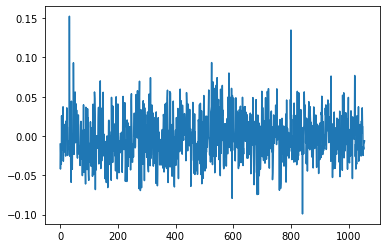

In [4]:
bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string
bin_strings

symbols = encode_bitstr2symbols(bin_strings)
print(len(symbols))
#frame = symbol_to_OFDMframes(symbols, len(symbols), prefix_no)[0] # original shape is (1, 1056)
frame = np.fft.ifft(symbols)
# Adding cyclic prefix
cyclic_prefix = frame[len(symbols)-prefix_no:len(symbols)]
        
frame = np.append(cyclic_prefix, frame, axis=0)       

#frame = np.real(frame)*10 # already has 0j part so make it real type
print(len(frame))
plt.plot(frame)

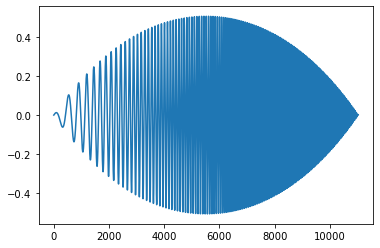

In [5]:
# linear chirp but can do log one
sec = 0.25

k = 10
fl = 60
fu = 1000

t = np.linspace(0, sec, int(fs*sec))
ch = chirp(t, f0=fl, f1=fu, t1=sec, method='linear') # can be linear, quadratic or logarithmic
ch *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))

ch = np.tile(ch, 1) # repeat num chirps

plt.plot(ch)

Chirp 1 starts at: 4410   OFDM starts at:  19845 Chirp 2 starts at:  129855
Transmitted diff:  15435


C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


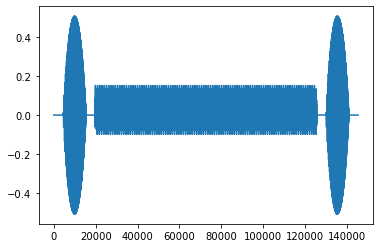

In [6]:
repeats = 100
repeat = np.tile(frame, repeats) # transmit repeated frames
gap = int(0.1*fs)
combined = np.concatenate((np.zeros(gap), ch, np.zeros(gap), repeat, np.zeros(gap), ch, np.zeros(gap)), axis=None)
print("Chirp 1 starts at:", gap, "  OFDM starts at: ", (2*gap)+len(ch), "Chirp 2 starts at: ", (3*gap)+len(ch)+len(repeat))
tx_diff = gap + len(ch)
print("Transmitted diff: ", tx_diff)
plt.plot(combined)

C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


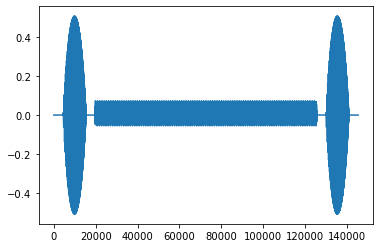

In [7]:
channel = [0.5, 0.25, 0, 0.25]
channel_op = np.convolve(channel, combined)
plt.plot(channel_op)

C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


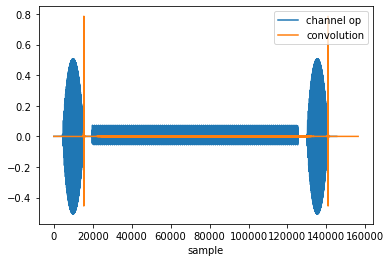

In [8]:
T = 0.0
inverse_ch = np.concatenate((np.zeros(int(T*fs)), np.flip(ch)), axis=None) # time reverse and delay the chirp
conv = np.convolve(channel_op, inverse_ch)
plt.plot(channel_op, label='channel op')
plt.plot(conv/1000, label='convolution')
plt.xlabel('sample')
plt.legend(loc='upper right')

Convolution peak 1: 15435
Convolution peak 2: 140880


C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


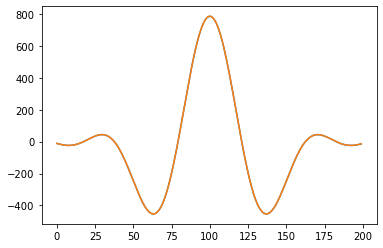

In [9]:
peak1 = np.argmax(conv[0:int(len(conv)/2)])
peak2 = np.argmax(conv[int(len(conv)/2):]) + int(len(conv)/2) + 0
print("Convolution peak 1:", peak1)
print("Convolution peak 2:", peak2)
plt.plot(conv[peak1-100:peak1+100])
plt.plot(conv[peak2-100:peak2+100])

In [10]:
combined.shape

(145290,)

In [11]:
channel_op.shape

(145293,)

19845 125445 105600
OFDM begins at:  19845
105600
Diff:  0


C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


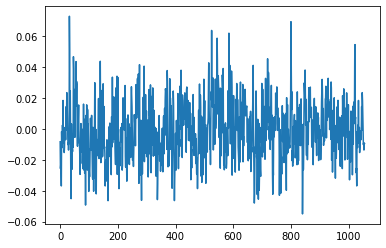

In [12]:
offset = 0 # current rough synchronisation error
rx_begin = peak1 + gap - int(T*fs) + offset # channel IR adjusts this value
rx_end = peak2 - gap - len(ch) - int(T*fs) + offset
print(rx_begin, rx_end, rx_end - rx_begin)
print("OFDM begins at: ", rx_begin) # offset proportional to length of channel IR
rx_OFDM = channel_op[rx_begin:rx_end] # mismatch between length of frames expected & received
print(len(rx_OFDM))
frames = np.split(rx_OFDM, repeats)
avg_frame = np.zeros(N + prefix_no)
for frame in frames:
    avg_frame = np.add(avg_frame, frame) # add all frames together
avg_frame /= repeats # divide by total num frames
#print(avg_frame)
plt.plot(avg_frame)
print("Diff: ", rx_begin - ((2*gap)+len(ch))) # number of symbol periods off

In [13]:
avg_frame.shape

(1056,)

C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


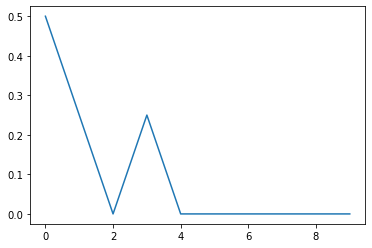

In [14]:
# remove cyclic prefix
avg_frame = avg_frame[prefix_no: N+prefix_no]

rx_dft = np.fft.fft(avg_frame)
norm_rx_dft = rx_dft / np.array(symbols)

imp_response = np.fft.ifft(norm_rx_dft)
#imp_response /= np.linalg.norm(imp_response)
plt.plot((imp_response)[0:10])
#print(imp_response[0:100])

In [58]:
imp_response[0:4]

array([5.00000000e-01-2.69017664e-17j, 2.50000000e-01+2.15197191e-17j,
       3.60562382e-17+9.91061403e-18j, 2.50000000e-01-2.68509444e-19j])

# ldpc
This package contains an implementation of encoders and 
decoders for the low-density parity-check (LDPC) codes
defined in the IEEE 802.11n and 802.16 families of standards.

Written by Jossy 2018

## Background info on IEEE LDPC codes

A basic knowledge of the codes in the standards is helpful:
the codes are designed via a protograph matrix.
Each entry in the matrix represents a zxz binary
cyclic shift matrix or a zxz all-zero matrix, where "-1" stands
for an all-zero matrix and any other entry represents the
magnitude of the shift (e.g. "0" is an identity matrix, i.e., 
shift by 0, while 1 is a matrix with an off-diagonal of 1s
and a 1 in the lower left corner, i.e., a matrix that performs
a left cyclic shift of its input vector). 

The 802.11n an 802.16 standards define protographs for codes
of rate 1/2, 2/3, 3/4 and 5/6. 802.11n supports z=27, 54 and 81
(where a protographs have been optimised for every combination
of rate and z), while 802.16 specifies unique protographs for
each rate that can be used with any choice of z (from z=3 upwards.)
802.16 has two optional designs (Type A and Type B) for rates
2/3 and 3/4, but only one design for rates 1/2 and 5/6.

The advantage of the IEEE 802.11n and 802.16 codes is that they
have very efficient encoders. 

## Requirements

The package is written for Python 3 and decoding functions are in C.
It's been tested on linux (CUED teaching system in DPO) and Mac OSX
High Sierra. You will need to have installed Python 3 and makes sure
you are actually using it (High Sierra comes with 2.7 by default, and
even if you've installed Python 3 you may still be using Python 2.7 
when typing "python" in a shell). You also need a compiler (gcc by
default installed on unix, if using Mac you need to install the 
"xcode command line tools"). Finally, if you want to try the automatic
testing functions, you need to install pytest (recommended approach
is to install anaconda, an package environment manager, then type
"conda install pytest"). Again, make sure pytest is using Python 3. 

## Contents and preparation

C code is in subdirectory `src/`
C executables are in subdirectory `bin/`
Python scripts classes and functions are in subdirectory `py/`
Results and data are in subdirectory `data/`

Compile the C code before first use:  
`gcc -lm -shared -fPIC -o bin/c_ldpc.so src/c_ldpc.c`  
`gcc -o bin/results2csv src/results2csv.c`

(the first of these needs to be done before decoders can be used!!)

## Description and usage

The following tools and libraries are provided:

### `py/ldpc.py`
This is the basic "code" class. It contains the following 
functions:

`ldpc.code(standard, rate, z, ptype)` initialises an ldpc object.  
`standard` is a string '802.11n' or '802.16'  
`rate` is a string (!!!) '1/2', '2/3', '3/4', '5/6'  
`z` is a number >= 3  
`ptype` is 'A' or 'B' (only needed for 802.16, rate 2/3 or 3/4)

The initialiser can be called for example as `c = ldpc.code()`  
(we will use "c" as the object name in the function descriptions below)

`c.pcmat()` returns the binary parity-check matrix 

`x = c.encode(u)` encodes the information vector u using an efficient
  encoder specialised to the IEEE standards families of LDPC codes.

`app,it = c.decode(y, dectype, corrfactor)` decodes the channel
  observation vector y to yield a-posteriori L-values app and a number
  of iterations it (at most 200, dynamically stopped using a stopping
  criterion.) dectype is either 'sumprod', 'sumprod2' or 'minsum'.
  'sumprod' is the regular sum-product algorithm
  'sumprod2' has an improved check node processing in the log domain 
  and is hence numerically more stable (and equivalent to sumprod)
  'minsum' is the min-sum algorithm. This algorithm can take an optional
   "correction factor" as an argument that can improve its performance.   
  WARNING: minsum currently NOT working, work in progress.  
  NOTE: the python function is a wrapper for underlying C functions. You
    MUST compiles these using the first `gcc` instruction above before
    importing `py/ldpc.py`

You can access code parameters using `c.K` (info length), `c.N` (codeword
  length), `c.Nv` (number of variable nodes, `= c.N`), `c.Nc` (number of
  constraint nodes), `c.Nmsg` (number of messages), `c.vdeg` (variable node
  degrees), `c.cdeg` (constraint node degrees), `c.intrlv` (code interleaver),
  `c.standard` (IEEE standard), `c.rate` (code rate string), `c.z` (z parameter
  of IEEE standard), `c.ptype` (code type for 802.16 rate 2/3 and 3/4), and
  finally `c.proto` (protograph)

### Example command-line use of `py/ldpc.py`:

NOTE: in current python version, a subdirectory must contain an empty
file `__init.py__` in order to be able to load a library from it in
command-line mode, whereas the opposite is true when not operating in 
command line mode. In the steps below, we write this file the delete it.

`$ cd ldpc`  
`$ echo " " > py/__init__.py`  
`$ python`  
`>>> import py.ldpc as ldpc`  
`>>> import numpy as np`  
`>>> c = ldpc.code()`  
`>>> c.standard`  
`'802.11n'`  
`>>> u = np.random.randint(0,2,c.K)`  
`>>> x = c.encode(u)`  
`>>> np.mod(np.matmul(x,np.transpose(c.pcmat())), 2)`  
`array([0, 0, ..., 0])`  
`>>> y = 10*(.5-x)`  
`>>> app,it = c.decode(y)`  
`>>> it`  
`0`  
`>>> np.nonzero((app<0) != x)`  
`(array([], dtype=int64),)`  
`>>> exit()`  
`$ rm py/__init__.py`  

### `py/test_ldpc.py`

Runs tests of the basic functions in ldpc.py for every combination
of parameters. The tests involve encoding a random binary word and
verifying that xH^T=0 (zero syndrome). It is not possible to design
formal test for the actual bit / word error performance of the 
decoders. These need to be examined by simulation and benchmarked
against existing published performance graphs. 
 
### `py/ldpc_awgn.py`

Runs a measurement campaign for LDPC codes on Additive White Gaussian
Noise (AWGN) channels. Usage:  
`python py/ldpc_awgn sim_id`  
where `sim_id` is a number between 1 and 36 determining the parameters
of the simulation (this was designed to work on a computer grid engine
that can run such commands in parallel with paramters 1-36). View the
file ldpc_awgn.py to see the list of parameters corresponding to sim_id
(e.g. `sim_id = 7` is 802.16, rate 1/2, z=27)

Writes all results into a file called `data/results.txt`  

A separate C programme (bin/results2csv) can be used to 
parse this file and convert it to CSV format. Finally,
a further python script `py/disp_res.py` extracts the results
from the file, sorts them back by parameters, and displays
a series of performance graphs (see below).

The directory `data/` is pre-loaded with a file `results.txt` from a 
measurement campaign conducted in September 2018. Running
such campaigns requires considerable computing power and
could take months on a single computer. 


### `disp_res.py`

Displays the performance results recorded in data/results.csv

WARNING: you must call `bin/results2csv` before calling this!
Calling `bin/results2csv` without arguments will read a file 
`data/results.txt` and wrote `data/results.csv`. An optional
command-line argument `prefix` will read and write `prefix.txt`
and `prefix.csv`, respectively, where "prefix" can include 
a directory path, e.g., `/home/user/me/ldpc/data/myresults`

Calling `python py/disp_results.py` without arguments will display
all results as python figures and wait until you've closed all
the corresponding windies.

Calling `python py/disp_results filename.pdf` will save the graphs
to the specified PDF file. 

